In [ ]:
!pip install missingno

In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import missingno as msno
from scipy.stats import chi2_contingency
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

## first session

In [ ]:
# Assuming mentalhealth.csv and gdp.csv are in the current working directory
# If they are in a different location, provide the full path
try:
    mental_health_df = pd.read_csv('mentalhealth.csv')
    gdp_df = pd.read_csv('gdp.csv')
    print("Files loaded successfully.")
    print("Mental Health DataFrame:")
    print(mental_health_df)
    print("\nGDP DataFrame:")
    print(gdp_df.head())  # Display the first few rows
except FileNotFoundError:
    print("Error: One or both of the files were not found.  Please ensure they are in the correct location.")
except Exception as e:
    print(f"An error occurred: {e}")


Files loaded successfully.
Mental Health DataFrame:
      sitecode                     sitename  sitetype  sitetypenum  year  \
0           AB         Albuquerque, NM (AB)  District            1  2023   
1           AB         Albuquerque, NM (AB)  District            1  2023   
2           AB         Albuquerque, NM (AB)  District            1  2023   
3           AB         Albuquerque, NM (AB)  District            1  2023   
4           AB         Albuquerque, NM (AB)  District            1  2023   
...        ...                          ...       ...          ...   ...   
22123       SP  Spartanburg County, SC (SP)  District            1  2023   
22124       SP  Spartanburg County, SC (SP)  District            1  2023   
22125       SP  Spartanburg County, SC (SP)  District            1  2023   
22126       SP  Spartanburg County, SC (SP)  District            1  2023   
22127       SP  Spartanburg County, SC (SP)  District            1  2023   

       survyear  weight  stratum  P

### Initial Data Cleaning

In [ ]:
for col in mental_health_df.columns:
  if mental_health_df[col].nunique() <=1:
    print(col, mental_health_df[col].nunique())

sitetype 1
sitetypenum 1
year 1
survyear 1
qhallucdrug 0
qmusclestrength 0
qsportsdrink 0
qsunburn 0
qunfairlydisc 0


In [ ]:
columns_to_drop = [col for col in mental_health_df.columns if mental_health_df[col].nunique() <= 1]
mental_health_df = mental_health_df.drop(columns=columns_to_drop)
mental_health_df = mental_health_df.drop(columns=['sitecode'])
mental_health_df

,sitename,weight,stratum,PSU,record,age,sex,grade,race4,race7,...,qphyabuseace,qphyviolenceace,qsexabuseace,qtalkadultace,qtalkfriendace,qtransgender,qtreatbadlyace,qunfairlyace,qverbalabuseace,qwater
0,"Albuquerque, NM (AB)",10.30,12,1,4,NaN,NaN,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Albuquerque, NM (AB)",1.58,16,3,5746,3.0,NaN,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Albuquerque, NM (AB)",10.60,2,7,5747,3.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Albuquerque, NM (AB)",1.69,16,3,5748,3.0,NaN,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Albuquerque, NM (AB)",9.55,3,3,5749,3.0,NaN,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22123,"Spartanburg County, SC (SP)",8.21,3,4,2297558,7.0,1.0,4.0,1.0,6.0,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,7.0
22124,"Spartanburg County, SC (SP)",10.31,3,1,2297559,7.0,1.0,4.0,1.0,6.0,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0
22125,"Spartanburg County, SC (SP)",4.41,6,3,2297560,7.0,1.0,4.0,3.0,4.0,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,7.0
22126,"Spartanburg County, SC (SP)",7.98,6,3,2297561,7.0,1.0,4.0,1.0,6.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,7.0


In [ ]:
# Count original rows
original_row_count = mental_health_df.shape[0]

# Add temporary column
mental_health_df['missing_values_count'] = mental_health_df.isnull().sum(axis=1)

# Drop rows with too many missing values
mental_health_df = mental_health_df[mental_health_df['missing_values_count'] <= 60]

# Drop helper column
mental_health_df.drop(columns=['missing_values_count'], inplace=True)

# Print results
print(f"Rows dropped: {original_row_count - mental_health_df.shape[0]}")
print(f"Remaining rows: {mental_health_df.shape[0]}")


Rows dropped: 2446
Remaining rows: 19682


<ipython-input-5-54178c693033>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df.drop(columns=['missing_values_count'], inplace=True)


<Axes: >

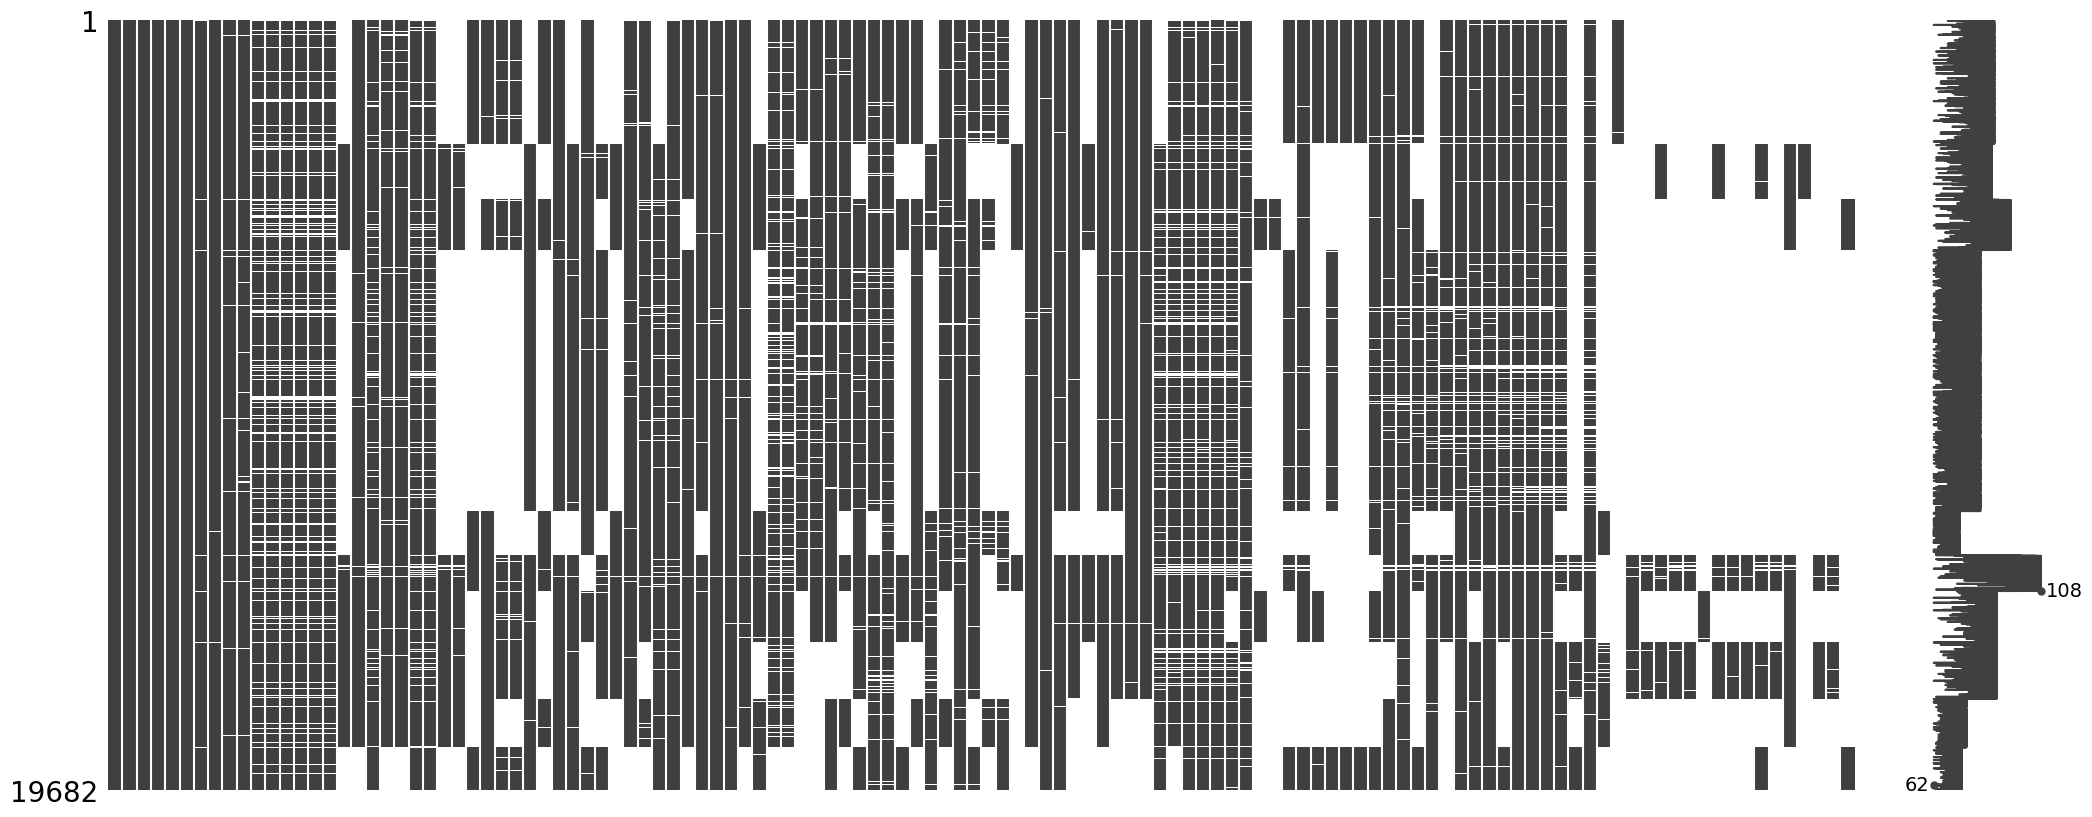

In [ ]:
msno.matrix(mental_health_df)

In [ ]:
numeric_columns = ['stheight', 'stweight', 'bmi', 'bmipct']
mental_health_df[numeric_columns].describe()

,stheight,stweight,bmi,bmipct
count,17121.000000,17121.000000,17121.000000,1.712100e+04
mean,1.677926,65.487699,23.171922,6.095197e+01
std,0.100418,17.142203,5.325098,2.985224e+01
min,1.300000,29.030000,12.050000,2.970000e-08
25%,1.600000,54.430000,19.630000,3.757000e+01
50%,1.680000,61.240000,21.890000,6.620000e+01
75%,1.750000,72.580000,25.290000,8.818000e+01
max,2.030000,180.990000,62.990000,9.996000e+01


In [ ]:
# Get all other columns as categorical (excluding numeric ones)
categorical_columns = [col for col in mental_health_df.columns if col not in numeric_columns]

# Create a summary DataFrame for categorical variables
cat_info = []

for col in categorical_columns:
    cat_info.append([
        col,
        mental_health_df[col].nunique(dropna=False),
        mental_health_df[col].unique(),
        mental_health_df[col].dtype
    ])

df_categorical_info = pd.DataFrame(cat_info, columns=['column_name', 'unique_count', 'unique_values', 'data_type'])

# Show the summary table
print("===== Categorical Variable Summary =====")
print(df_categorical_info)

# Step 3: Print value counts for each categorical variable
print("\n===== Value Counts for Each Categorical Variable =====")
for col in categorical_columns:
    print(f"\n--- {col} ---")
    print(mental_health_df[col].value_counts(dropna=False))

===== Categorical Variable Summary =====
         column_name  unique_count  \
0           sitename            10   
1             weight          3619   
2            stratum            45   
3                PSU            41   
4             record         19682   
..               ...           ...   
113     qtransgender             5   
114   qtreatbadlyace             6   
115     qunfairlyace             6   
116  qverbalabuseace             6   
117           qwater             8   

                                         unique_values data_type  
0    [Albuquerque, NM (AB), Chicago, IL (CH), Los A...    object  
1    [10.3, 1.58, 10.6, 1.69, 9.55, 11.87, 8.22, 10...   float64  
2    [12, 16, 2, 3, 1, 11, 7, 15, 4, 5, 8, 6, 10, 1...     int64  
3    [1, 3, 7, 6, 14, 12, 13, 5, 38, 16, 15, 11, 9,...     int64  
4    [4, 5746, 5747, 5748, 5749, 5750, 7578, 7579, ...     int64  
..                                                 ...       ...  
113                          [nan

In [ ]:
gdp_df

,"Table 1. Real Gross Domestic Product, by County, 2020–2023",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,Real gross domestic product,NaN,NaN,NaN,NaN,Percent change from preceding period,NaN,NaN,NaN
1,NaN,Thousands of chained (2017) dollars,NaN,NaN,NaN,Rank in state,Percent change,NaN,NaN,Rank in state
2,NaN,2020,2021,2022,2023,2023,2021,2022.0,2023.0,2023
3,United States,"20,267,585,000","21,494,798,000","22,034,828,000","22,671,096,000",--,6.1,2.5,2.9,--
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3218,Uinta,"781,034","808,678","836,424","870,000",13,3.5,3.4,4.0,17
3219,Washakie,"342,040","346,039","339,019","347,700",19,1.2,-2.0,2.6,20
3220,Weston,"290,300","295,003","289,622","317,107",21,1.6,-1.8,9.5,6
3221,1. Virginia combination areas consist of one o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
gdp_df.columns

Index(['Table 1. Real Gross Domestic Product, by County, 2020–2023',
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],
      dtype='object')

In [ ]:
gdp_df_edited = gdp_df.drop(columns=[
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3',  'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'])

gdp_df_edited = gdp_df_edited[5:]
gdp_df_edited

,"Table 1. Real Gross Domestic Product, by County, 2020–2023",Unnamed: 4
5,Alabama,"245,354,674"
6,Autauga,"1,945,909"
7,Baldwin,"9,435,720"
8,Barbour,"715,994"
9,Bibb,"466,543"
...,...,...
3218,Uinta,"870,000"
3219,Washakie,"347,700"
3220,Weston,"317,107"
3221,1. Virginia combination areas consist of one o...,NaN


In [ ]:
# prompt: rename first column to 'state' second column to 'gdp 2023' in gdp_df_edited

gdp_df_edited = gdp_df_edited.rename(columns={gdp_df_edited.columns[0]:'state', gdp_df_edited.columns[1]:'gdp 2023'})
gdp_df_edited

,state,gdp 2023
5,Alabama,"245,354,674"
6,Autauga,"1,945,909"
7,Baldwin,"9,435,720"
8,Barbour,"715,994"
9,Bibb,"466,543"
...,...,...
3218,Uinta,"870,000"
3219,Washakie,"347,700"
3220,Weston,"317,107"
3221,1. Virginia combination areas consist of one o...,NaN


In [ ]:
mental_health_df['sitename'].unique()

array(['Albuquerque, NM (AB)', 'Chicago, IL (CH)', 'Los Angeles, CA (LO)',
       'New York City, NY (NYC)', 'Oakland, CA (OA)',
       'Philadelphia, PA (PH)', 'Portland, OR (PO)', 'San Diego, CA (SA)',
       'Seattle, WA (SE)', 'Spartanburg County, SC (SP)'], dtype=object)

In [ ]:
cities_states = {
    "Albuquerque": "New Mexico",
    "Chicago": "Illinois",
    "Los Angeles": "California",
    "New York City": "New York",
    "Oakland": "California",
    "Philadelphia": "Pennsylvania",
    "Portland": "Oregon",
    "San Diego": "California",
    "Seattle": "Washington",
    "Spartanburg County": "South Carolina"
}

In [ ]:
df_mental_health_with_gdp = mental_health_df.copy()

In [ ]:
gdp_df_edited

,state,gdp 2023
5,Alabama,"245,354,674"
6,Autauga,"1,945,909"
7,Baldwin,"9,435,720"
8,Barbour,"715,994"
9,Bibb,"466,543"
...,...,...
3218,Uinta,"870,000"
3219,Washakie,"347,700"
3220,Weston,"317,107"
3221,1. Virginia combination areas consist of one o...,NaN


In [ ]:
df_mental_health_with_gdp['state'] = df_mental_health_with_gdp['sitename'].apply(lambda x: cities_states[x.split(', ')[0]] if x.split(', ')[0] in cities_states else None)

In [ ]:
df_mental_health_with_gdp['gdp 2023'] = df_mental_health_with_gdp['state'].apply(lambda x: gdp_df_edited[gdp_df_edited['state'] == x]['gdp 2023'].values[0] if x is not None else None)

In [ ]:
df_mental_health_with_gdp.to_csv('mental_health_with_gdp.csv', index=False)

In [ ]:
df_mental_health_with_gdp['gdp 2023']

,gdp 2023
0,"110,323,705"
1,"110,323,705"
2,"110,323,705"
3,"110,323,705"
4,"110,323,705"
...,...
22123,"262,298,502"
22124,"262,298,502"
22125,"262,298,502"
22126,"262,298,502"


## second session

In [ ]:
df = pd.read_csv('mental_health_with_gdp.csv')

In [ ]:
df.head()

,sitename,weight,stratum,PSU,record,age,sex,grade,race4,race7,...,qsexabuseace,qtalkadultace,qtalkfriendace,qtransgender,qtreatbadlyace,qunfairlyace,qverbalabuseace,qwater,state,gdp 2023
0,"Albuquerque, NM (AB)",10.30,12,1,4,NaN,NaN,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"
1,"Albuquerque, NM (AB)",1.58,16,3,5746,3.0,NaN,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"
2,"Albuquerque, NM (AB)",10.60,2,7,5747,3.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"
3,"Albuquerque, NM (AB)",1.69,16,3,5748,3.0,NaN,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"
4,"Albuquerque, NM (AB)",9.55,3,3,5749,3.0,NaN,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"


In [ ]:
col_info=[]

for col in df.columns:
  col_info.append([col,df[col].nunique(),df[col].unique(),df[col].dtype])

df_cols = pd.DataFrame(col_info, columns=['column_name','unique_num','unique_values','data_type'])
df_cols.head()

,column_name,unique_num,unique_values,data_type
0,sitename,10,"[Albuquerque, NM (AB), Chicago, IL (CH), Los A...",object
1,weight,3619,"[10.3, 1.58, 10.6, 1.69, 9.55, 11.87, 8.22, 10...",float64
2,stratum,45,"[12, 16, 2, 3, 1, 11, 7, 15, 4, 5, 8, 6, 10, 1...",int64
3,PSU,41,"[1, 3, 7, 6, 14, 12, 13, 5, 38, 16, 15, 11, 9,...",int64
4,record,19682,"[4, 5746, 5747, 5748, 5749, 5750, 7578, 7579, ...",int64


In [ ]:
df_cols.sort_values(by='unique_num', ascending=False)

,column_name,unique_num,unique_values,data_type
4,record,19682,"[4, 5746, 5747, 5748, 5749, 5750, 7578, 7579, ...",int64
13,bmipct,4506,"[nan, 76.67, 55.7, 75.24, 15.48, 72.96, 53.23,...",float64
1,weight,3619,"[10.3, 1.58, 10.6, 1.69, 9.55, 11.87, 8.22, 10...",float64
12,bmi,1662,"[nan, 20.99, 19.15, 20.82, 16.67, 20.58, 18.99...",float64
11,stweight,266,"[nan, 57.15, 52.16, 56.7, 49.9, 66.68, 54.89, ...",float64
...,...,...,...,...
73,q56,2,"[nan, 1.0, 2.0]",float64
107,qincarparentace,2,"[nan, 2.0, 1.0]",float64
114,qsexabuseace,2,"[nan, 2.0, 1.0]",float64
109,qlivedwabuseace,2,"[nan, 2.0, 1.0]",float64


In [ ]:
df_states= pd.read_csv('joined_state_data.csv')

In [ ]:
df_states

,state,Unemployment Rate(Percent),Mean household income (dollars)
0,Washington,4.5%,"129,161"
1,South Carolina,4.3%,"92,578"
2,Pennsylvania,4.2%,"102,578"
3,Oregon,4.1%,"107,214"
4,New York,5.0%,"122,227"
5,New Mexico,4.8%,"85,782"
6,Illinois,4.7%,"110,930"
7,California,5.5%,"134,491"


In [ ]:
df = df.merge(df_states, how='left', on='state')
df.to_csv('mental_health_with_socioeconomic_indicators.csv', index=False)
df


,sitename,weight,stratum,PSU,record,age,sex,grade,race4,race7,...,qtalkfriendace,qtransgender,qtreatbadlyace,qunfairlyace,qverbalabuseace,qwater,state,gdp 2023,Unemployment Rate(Percent),Mean household income (dollars)
0,"Albuquerque, NM (AB)",10.30,12,1,4,NaN,NaN,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
1,"Albuquerque, NM (AB)",1.58,16,3,5746,3.0,NaN,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
2,"Albuquerque, NM (AB)",10.60,2,7,5747,3.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
3,"Albuquerque, NM (AB)",1.69,16,3,5748,3.0,NaN,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
4,"Albuquerque, NM (AB)",9.55,3,3,5749,3.0,NaN,1.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19677,"Spartanburg County, SC (SP)",8.21,3,4,2297558,7.0,1.0,4.0,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,7.0,South Carolina,"262,298,502",4.3%,"92,578"
19678,"Spartanburg County, SC (SP)",10.31,3,1,2297559,7.0,1.0,4.0,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,4.0,South Carolina,"262,298,502",4.3%,"92,578"
19679,"Spartanburg County, SC (SP)",4.41,6,3,2297560,7.0,1.0,4.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,7.0,South Carolina,"262,298,502",4.3%,"92,578"
19680,"Spartanburg County, SC (SP)",7.98,6,3,2297561,7.0,1.0,4.0,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,7.0,South Carolina,"262,298,502",4.3%,"92,578"


## Handling Missing Data

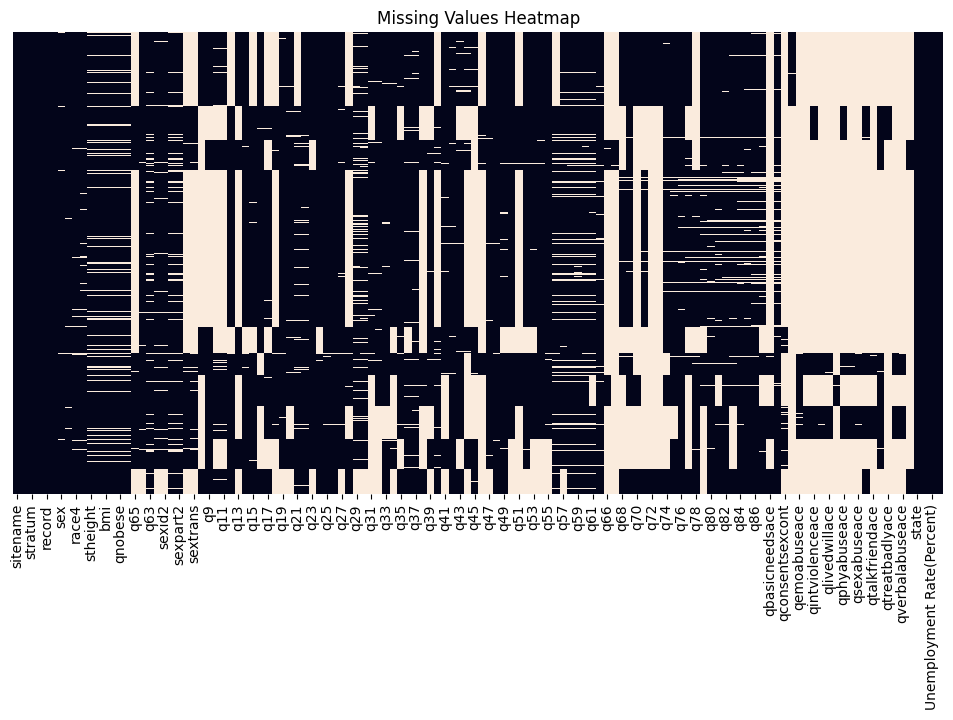

In [ ]:
df = pd.read_csv('mental_health_with_socioeconomic_indicators.csv')
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [ ]:
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

q67                    18409
qparentalmonitoring    18388
qtreatbadlyace         18268
qlivedwillace          17468
qincarparentace        17466
                       ...  
q26                      135
grade                    126
sex                      121
q25                      114
age                       30
Length: 117, dtype: int64


In [ ]:
# Set threshold for high missingness (70%)
threshold = 0.70

# Calculate fraction of missing values per column
missing_fraction = df.isnull().mean()

# Identify columns exceeding the threshold
high_missing_cols = missing_fraction[missing_fraction > threshold].index.tolist()

# Print summary
print(f"Columns with >{int(threshold * 100)}% missing values:")
print(high_missing_cols)

# Drop them from the DataFrame
df.drop(columns=high_missing_cols, inplace=True)

print(f"\nDropped {len(high_missing_cols)} columns due to high missingness.")
print(f"Remaining columns: {df.shape[1]}")



Columns with >70% missing values:
['q46', 'q51', 'q66', 'q67', 'q70', 'q72', 'q73', 'qbasicneedsace', 'qconsentsexcont', 'qcurrentopioid', 'qemoabuseace', 'qincarparentace', 'qintviolenceace', 'qlivedwabuseace', 'qlivedwillace', 'qparentalmonitoring', 'qphyabuseace', 'qphyviolenceace', 'qsexabuseace', 'qtalkadultace', 'qtalkfriendace', 'qtreatbadlyace', 'qunfairlyace', 'qverbalabuseace', 'qwater']

Dropped 25 columns.
Remaining columns: 101

Dropped 25 columns due to high missingness.
Remaining columns: 101


In [ ]:
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

q44         13435
q8          13391
q45         12573
sextrans    12354
transg      12236
            ...  
q26           135
grade         126
sex           121
q25           114
age            30
Length: 92, dtype: int64


In [ ]:
# Step 1: Define numeric columns
numeric_columns = ['stheight', 'stweight', 'bmi', 'bmipct']

# Step 2: Identify categorical columns (everything else)
categorical_columns = [col for col in df.columns if col not in numeric_columns]

# Step 3: Fill missing values in categorical columns with "-1"
for col in categorical_columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(-1)

# Fill each with its mean
for col in numeric_columns:
    mean_value = df[col].mean()
    df[col] = df[col].fillna(mean_value)
    print(f"Filled missing values in '{col}' with mean: {mean_value:.2f}")

Filled missing values in 'stheight' with mean: 1.68
Filled missing values in 'stweight' with mean: 65.49
Filled missing values in 'bmi' with mean: 23.17
Filled missing values in 'bmipct' with mean: 60.95


In [ ]:
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

Series([], dtype: int64)


In [ ]:
df.to_csv('mental_health_full.csv', index=False)

## Third session

In [ ]:
full_df = pd.read_csv('mental_health_full.csv')
full_df

,sitename,weight,stratum,PSU,record,age,sex,grade,race4,race7,...,q84,q85,q86,q87,qclose2people,qtransgender,state,gdp 2023,Unemployment Rate(Percent),Mean household income (dollars)
0,"Albuquerque, NM (AB)",10.30,12,1,4,-1.0,-1.0,1.0,3.0,4.0,...,3.0,4.0,1.0,7.0,3.0,-1.0,New Mexico,"110,323,705",4.8%,"85,782"
1,"Albuquerque, NM (AB)",1.58,16,3,5746,3.0,-1.0,1.0,3.0,4.0,...,4.0,1.0,1.0,3.0,2.0,-1.0,New Mexico,"110,323,705",4.8%,"85,782"
2,"Albuquerque, NM (AB)",10.60,2,7,5747,3.0,-1.0,1.0,-1.0,-1.0,...,1.0,6.0,1.0,1.0,1.0,-1.0,New Mexico,"110,323,705",4.8%,"85,782"
3,"Albuquerque, NM (AB)",1.69,16,3,5748,3.0,-1.0,1.0,3.0,4.0,...,3.0,4.0,1.0,2.0,2.0,-1.0,New Mexico,"110,323,705",4.8%,"85,782"
4,"Albuquerque, NM (AB)",9.55,3,3,5749,3.0,-1.0,1.0,3.0,4.0,...,4.0,4.0,1.0,2.0,3.0,-1.0,New Mexico,"110,323,705",4.8%,"85,782"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19677,"Spartanburg County, SC (SP)",8.21,3,4,2297558,7.0,1.0,4.0,1.0,6.0,...,3.0,4.0,1.0,2.0,2.0,-1.0,South Carolina,"262,298,502",4.3%,"92,578"
19678,"Spartanburg County, SC (SP)",10.31,3,1,2297559,7.0,1.0,4.0,1.0,6.0,...,3.0,4.0,1.0,1.0,5.0,-1.0,South Carolina,"262,298,502",4.3%,"92,578"
19679,"Spartanburg County, SC (SP)",4.41,6,3,2297560,7.0,1.0,4.0,3.0,4.0,...,3.0,5.0,1.0,1.0,4.0,-1.0,South Carolina,"262,298,502",4.3%,"92,578"
19680,"Spartanburg County, SC (SP)",7.98,6,3,2297561,7.0,1.0,4.0,1.0,6.0,...,4.0,3.0,1.0,1.0,4.0,-1.0,South Carolina,"262,298,502",4.3%,"92,578"


Shape of dataset: (19682, 101)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19682 entries, 0 to 19681
Columns: 101 entries, sitename to Mean household income (dollars)
dtypes: float64(96), int64(3), object(2)
memory usage: 15.2+ MB
None

Summary statistics:
             weight       stratum           PSU        record           age  \
count  19682.000000  19682.000000  19682.000000  1.968200e+04  19682.000000   
mean      24.645036     12.124733      4.204654  1.115114e+06      4.662382   
std       24.159113     10.851588      5.133162  6.721238e+05      1.243479   
min        1.000000      1.000000      1.000000  4.000000e+00     -1.000000   
25%        7.320000      4.000000      1.000000  4.796322e+05      4.000000   
50%       13.165000      9.000000      2.000000  1.167250e+06      5.000000   
75%       37.940000     17.000000      5.000000  1.665050e+06      6.000000   
max      190.110000     45.000000     41.000000  2.297562e+06      7.000000   

                se

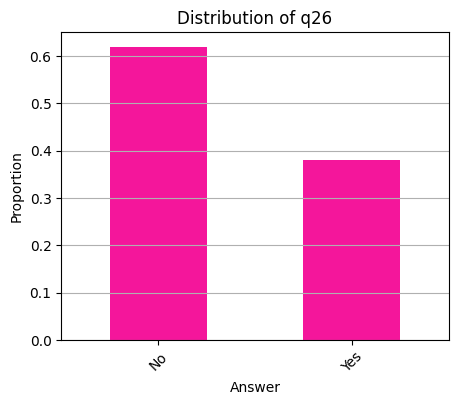

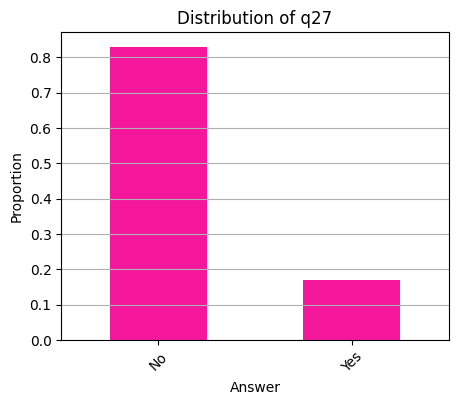

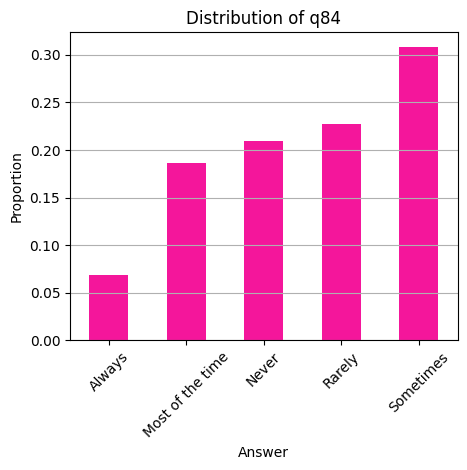

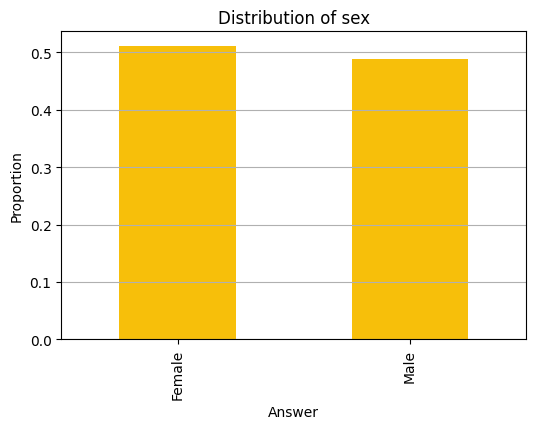

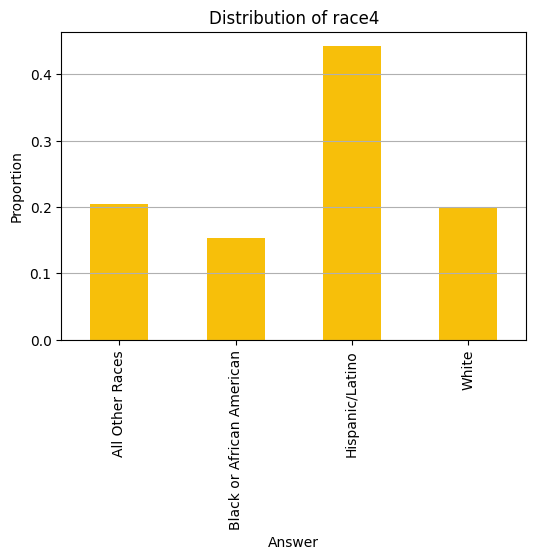

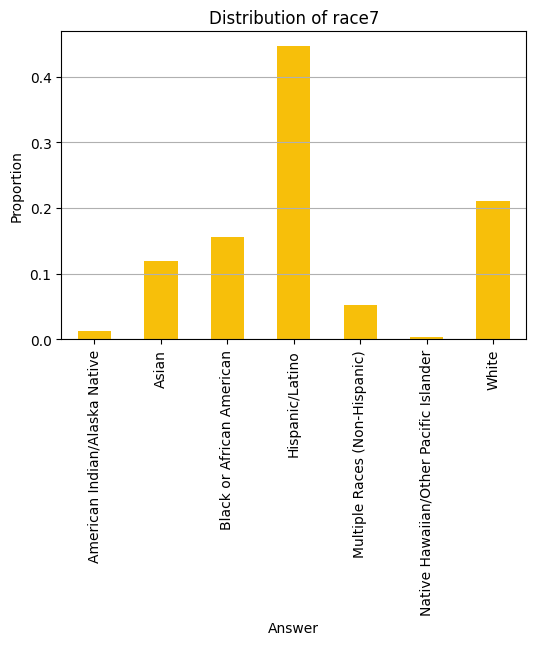

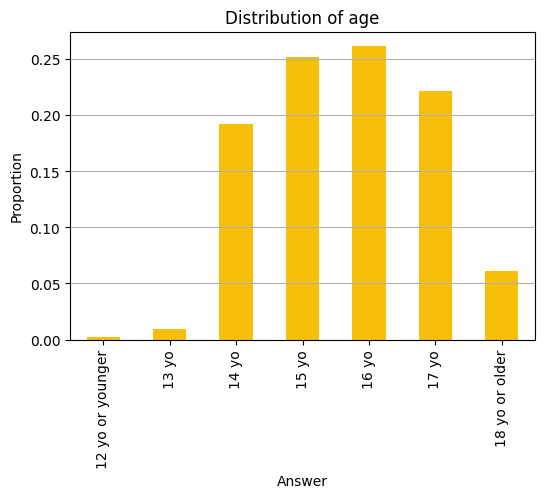

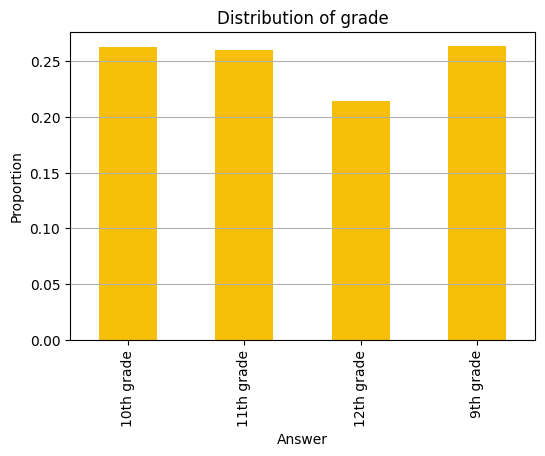

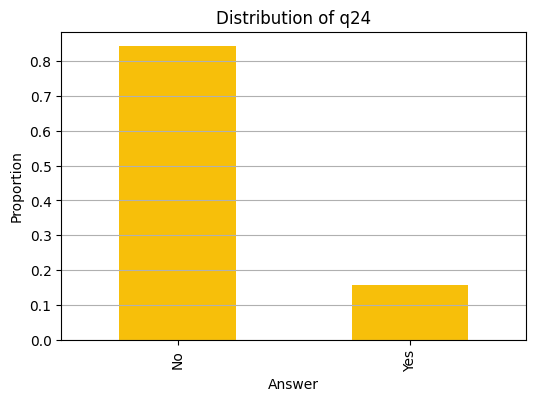

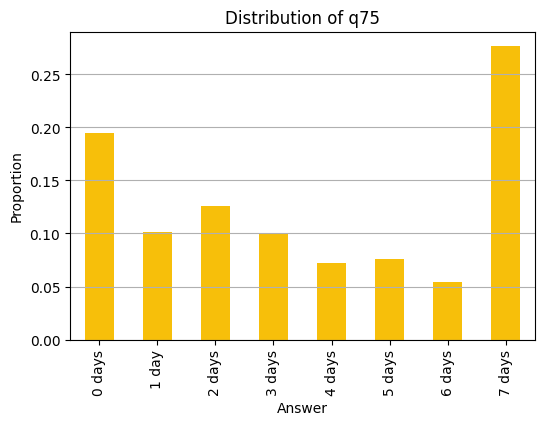

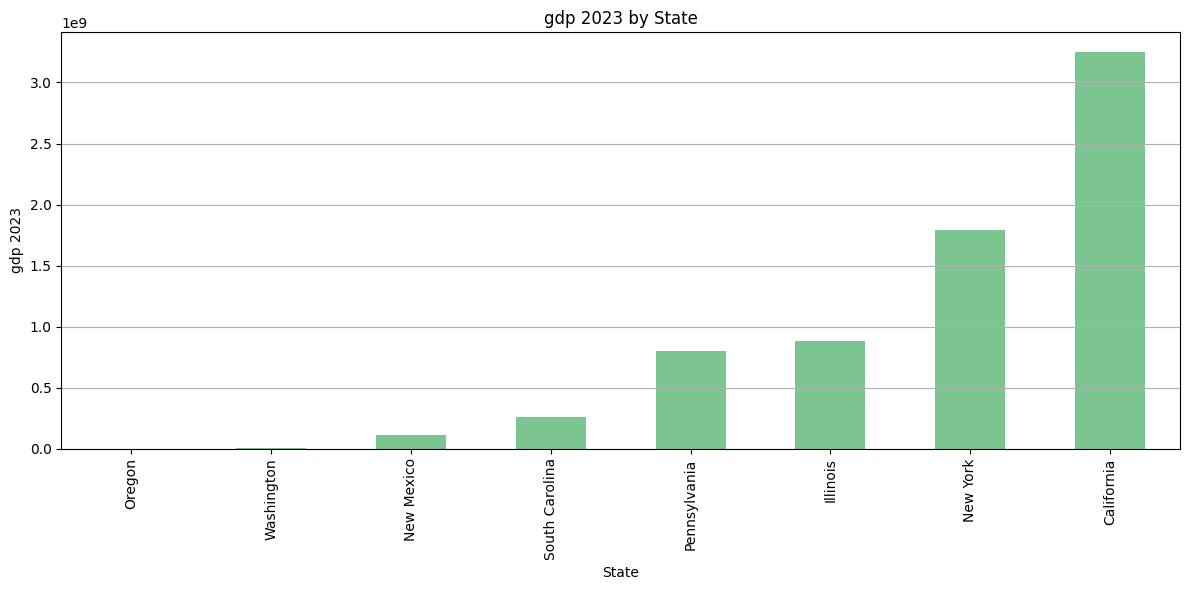

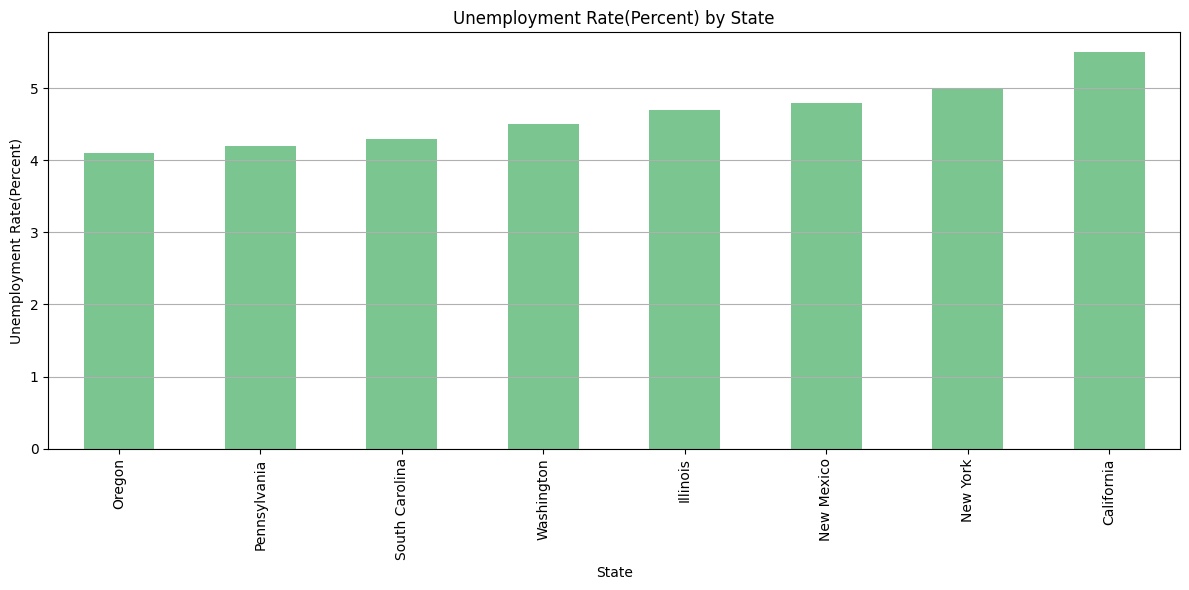

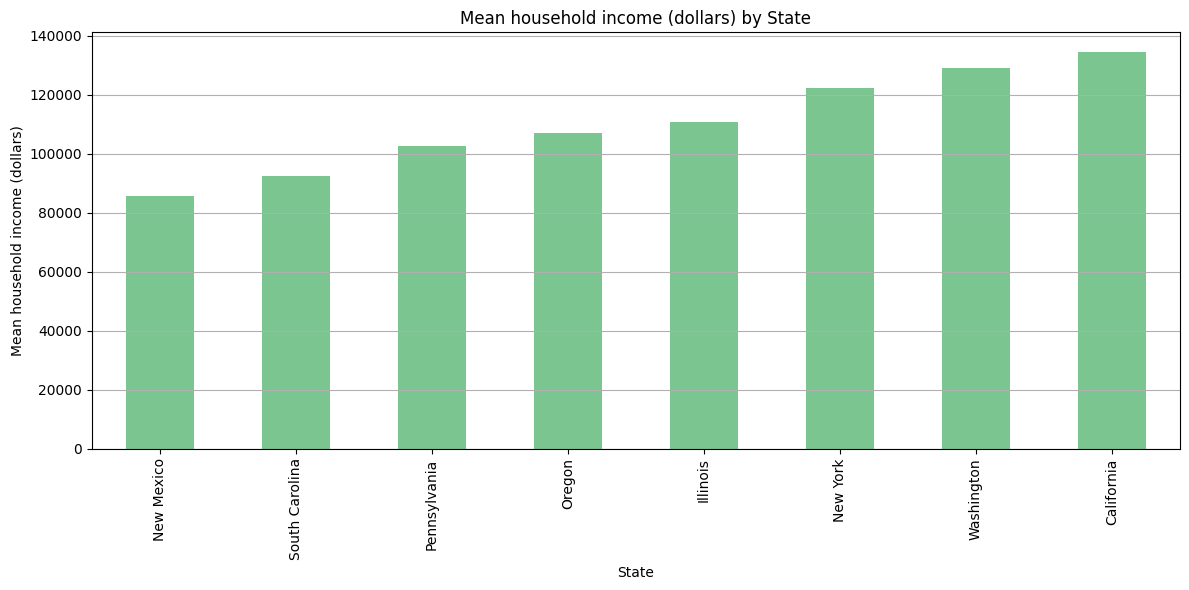

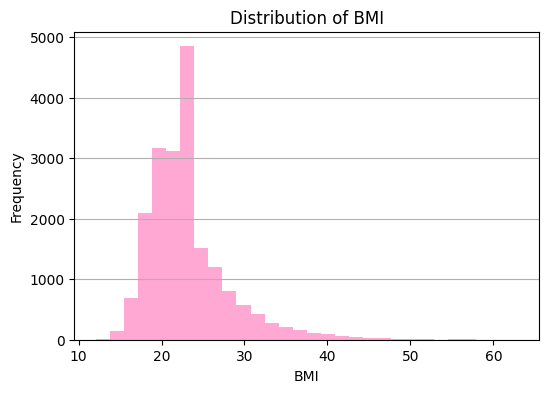

In [ ]:
# --- Basic Info ---
print("Shape of dataset:", full_df.shape)
print("\nInfo:")
print(full_df.info())
print("\nSummary statistics:")
print(full_df.describe())

# --- Missing Values ---
print("\nMissing values (sorted):")
missing_percent = full_df.isnull().mean() * 100
print(missing_percent[missing_percent > 0].sort_values(ascending=False))

# --- Mapping dictionaries for key categorical variables ---
mapping_dicts = {
    'q26': {1: 'Yes', 2: 'No'},
    'q27': {1: 'Yes', 2: 'No'},
    'q84': {
        1: 'Never',
        2: 'Rarely',
        3: 'Sometimes',
        4: 'Most of the time',
        5: 'Always'
    },
    'age': {
        1: '12 yo or younger',
        2: '13 yo',
        3: '14 yo',
        4: '15 yo',
        5: '16 yo',
        6: '17 yo',
        7: '18 yo or older'
    },
    'sex': {
        1: 'Female',
        2: 'Male'
    },
    'grade': {
        1: '9th grade',
        2: '10th grade',
        3: '11th grade',
        4: '12th grade',
        5: 'Ungraded or other grade'
    },
    'race4': {
        1: 'White',
        2: 'Black or African American',
        3: 'Hispanic/Latino',
        4: 'All Other Races'
    },
    'race7': {
        1: 'American Indian/Alaska Native',
        2: 'Asian',
        3: 'Black or African American',
        4: 'Hispanic/Latino',
        5: 'Native Hawaiian/Other Pacific Islander',
        6: 'White',
        7: 'Multiple Races (Non-Hispanic)'
    },
    'q24': {
        1: 'Yes',
        2: 'No'
    },
      'q75': {
        1: '0 days',
        2: '1 day',
        3: '2 days',
        4: '3 days',
        5: '4 days',
        6: '5 days',
        7: '6 days',
        8: '7 days'
    }
}

# --- Targets Distribution ---
import matplotlib.pyplot as plt
target_vars = ['q26', 'q27', 'q84']

for target in target_vars:
    if target in full_df.columns:
        if target in mapping_dicts:
            mapped_series = full_df[target].map(mapping_dicts[target])
        else:
            mapped_series = full_df[target]

        if mapped_series.dropna().shape[0] > 0:
            plt.figure(figsize=(5, 4))
            mapped_series.value_counts(normalize=True).sort_index().plot(kind='bar', color='#f4169b')
            plt.title(f'Distribution of {target}')
            plt.xlabel('Answer')
            plt.ylabel('Proportion')
            plt.xticks(rotation=45)
            plt.grid(axis='y')
            plt.show()
        else:
            print(f"Warning: {target} exists but has no non-missing values. Skipping plot.")
    else:
        print(f"Warning: {target} not found in dataset. Skipping plot.")

# --- Additional Categorical Variables Distribution ---
categorical_vars = ['sex', 'race4', 'race7', 'age', 'grade', 'q24', 'q75']

for var in categorical_vars:
    if var in full_df.columns:
        if var in mapping_dicts:
            mapped_series = full_df[var].map(mapping_dicts[var])
        else:
            mapped_series = full_df[var]

        if mapped_series.dropna().shape[0] > 0:
            plt.figure(figsize=(6, 4))
            mapped_series.value_counts(normalize=True).sort_index().plot(kind='bar', color='#f7bf0a')
            plt.title(f'Distribution of {var}')
            plt.xlabel('Answer')
            plt.ylabel('Proportion')
            plt.xticks(rotation=90)
            plt.grid(axis='y')
            plt.show()
        else:
            print(f"Warning: {var} exists but has no non-missing values. Skipping plot.")
    else:
        print(f"Warning: {var} not found in dataset. Skipping plot.")

import matplotlib.pyplot as plt

# Clean the numeric columns if they contain commas or percentage signs (only run once)
full_df['gdp 2023'] = full_df['gdp 2023'].astype(str).str.replace(',', '').astype(float)
full_df['Unemployment Rate(Percent)'] = full_df['Unemployment Rate(Percent)'].astype(str).str.replace('%', '').astype(float)
full_df['Mean household income (dollars)'] = full_df['Mean household income (dollars)'].astype(str).str.replace(',', '').astype(float)

# Columns to plot
columns_to_plot = ['gdp 2023', 'Unemployment Rate(Percent)', 'Mean household income (dollars)']

# Plot each variable
for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    full_df.groupby('state')[column].mean().sort_values().plot(kind='bar', color='#7ac590')
    plt.title(f"{column} by State")
    plt.xlabel("State")
    plt.ylabel(column)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()


# --- Histogram for BMI ---
if 'bmi' in full_df.columns:
    plt.figure(figsize=(6, 4))
    plt.hist(full_df['bmi'].dropna(), bins=30, color='#ffa8d3')
    plt.title('Distribution of BMI')
    plt.xlabel('BMI')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()
else:
    print("Feature 'bmi' not found.")


## Outliers

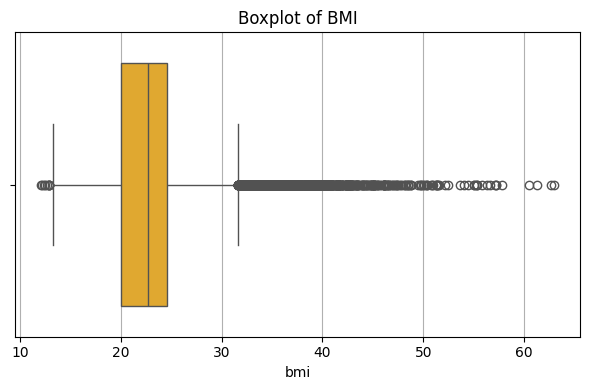

Number of BMI outliers: 1267 (6.44%)


In [ ]:
# --- 1. Visualize BMI with a boxplot ---
plt.figure(figsize=(6, 4))
sns.boxplot(data=full_df, x='bmi', color='#feb312')
plt.title('Boxplot of BMI')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# --- 2. Detect outliers using IQR ---
Q1 = full_df['bmi'].quantile(0.25)
Q3 = full_df['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Boolean mask of outliers
bmi_outliers = (full_df['bmi'] < lower_bound) | (full_df['bmi'] > upper_bound)

# Print outlier count
outlier_count = bmi_outliers.sum()
print(f"Number of BMI outliers: {outlier_count} ({round(100 * outlier_count / len(full_df), 2)}%)")

In [ ]:
# Prepare contingency table for q27 by BMI outlier status
# First, re-calculate IQR outlier flag for BMI
Q1 = full_df['bmi'].quantile(0.25)
Q3 = full_df['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
full_df['bmi_outlier'] = full_df['bmi'].apply(lambda x: 'Outlier' if x < lower_bound or x > upper_bound else 'Normal')

# Prepare the contingency table (drop missing q27 values)
contingency = pd.crosstab(full_df['bmi_outlier'], full_df['q27'])

# Run chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi² = {chi2:.2f}")
print(f"p-value = {p:.4f}")
print("Result: Significant association" if p < 0.05 else "Result: Not significant")

Chi² = 31.33
p-value = 0.0000
Result: Significant association


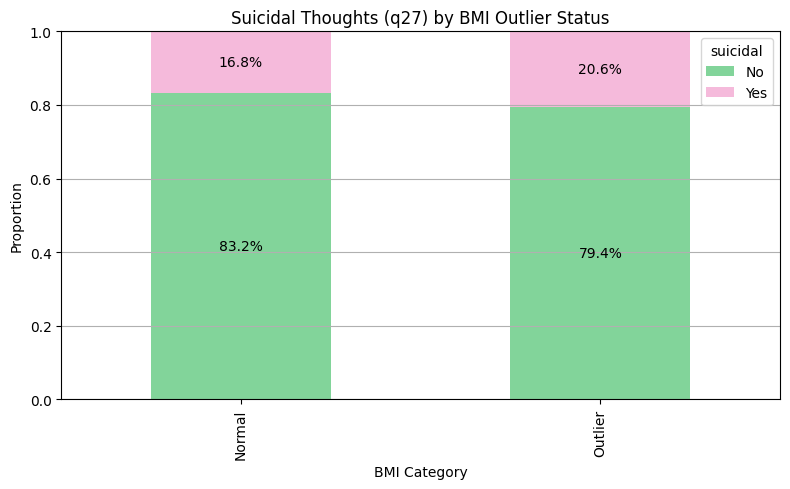

In [ ]:
# Prepare data
suicide_map = {1: 'Yes', 2: 'No'}
temp = full_df[['bmi_outlier', 'q27']].copy()
temp['suicidal'] = temp['q27'].map(suicide_map)
temp.dropna(inplace=True)

# Calculate proportions
suicide_rate = pd.crosstab(temp['bmi_outlier'], temp['suicidal'], normalize='index')

colors = ['#82d49a', '#f5badb']

# Plot
ax = suicide_rate.plot(kind='bar', stacked=True, figsize=(8, 5), color=colors)
plt.title('Suicidal Thoughts (q27) by BMI Outlier Status')
plt.xlabel('BMI Category')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()

# Add percentage labels
for i, bars in enumerate(ax.containers):
    for bar in bars:
        height = bar.get_height()
        if height > 0.01:  # skip very small bars
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{height:.1%}",
                ha='center',
                va='center',
                fontsize=10,
                color='black'
            )

plt.show()


## Bivariate/Multivariate Analysis

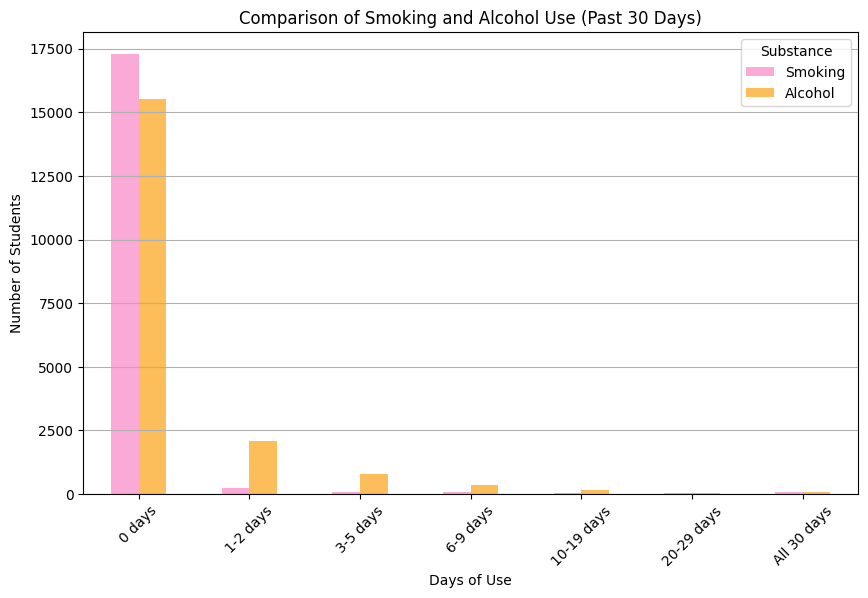

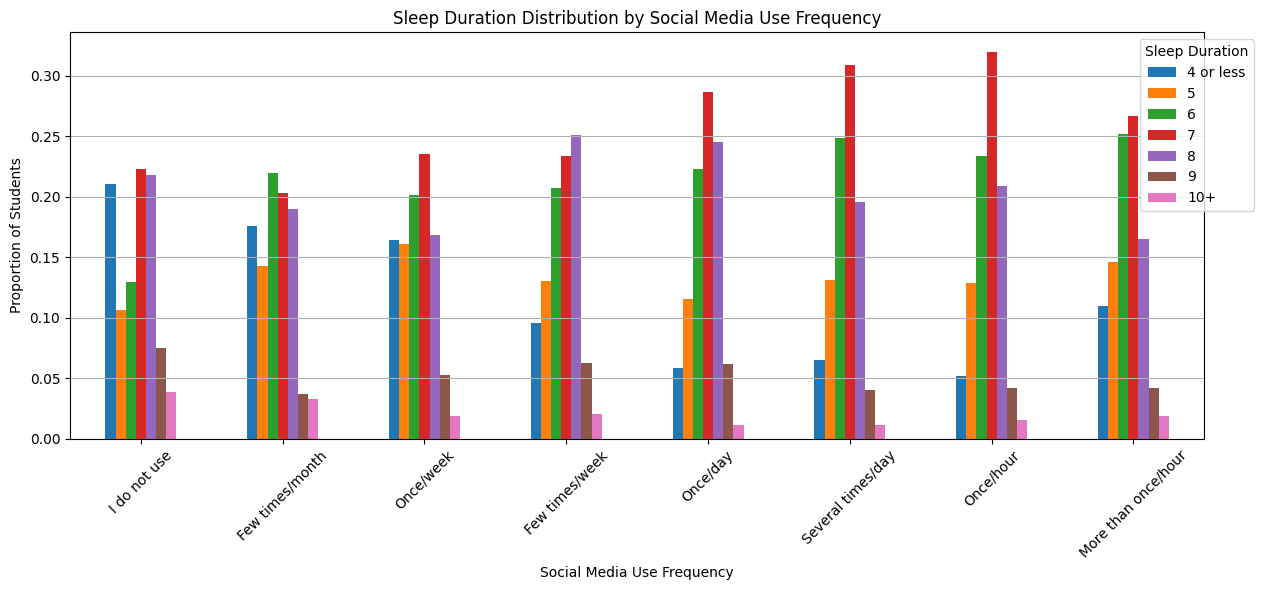

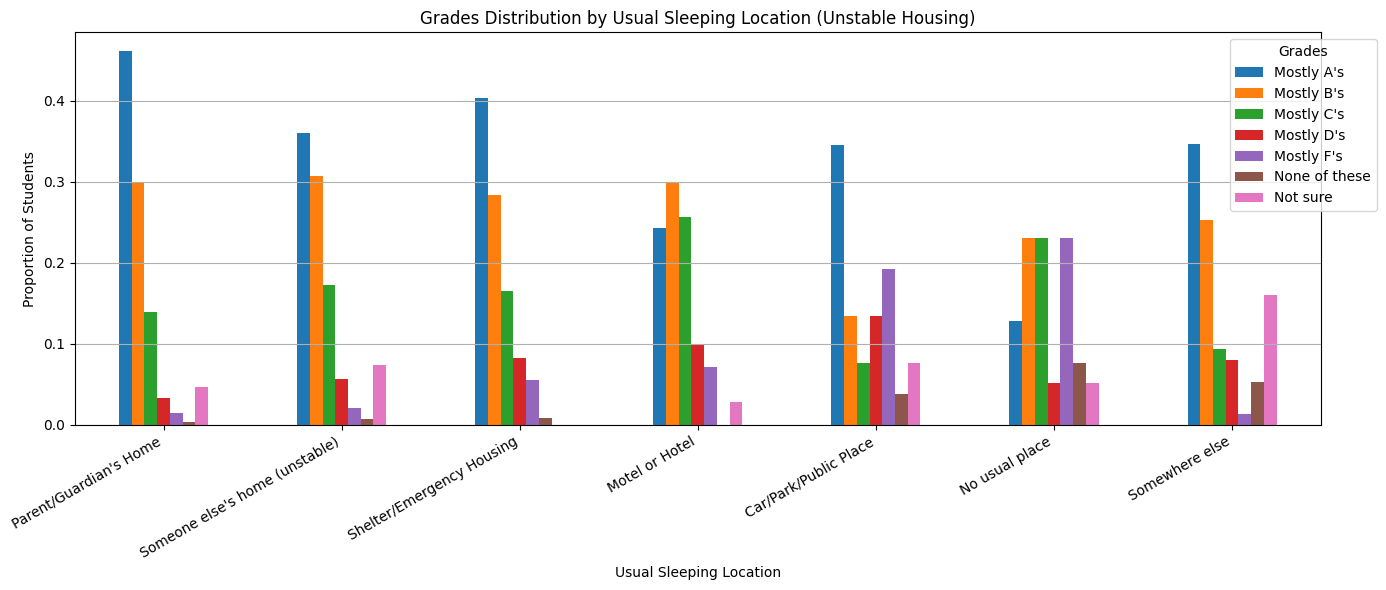

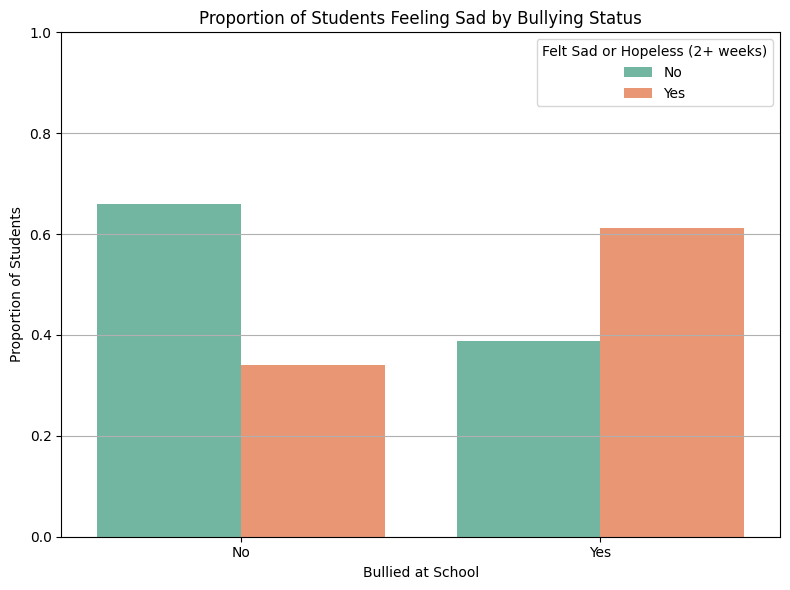

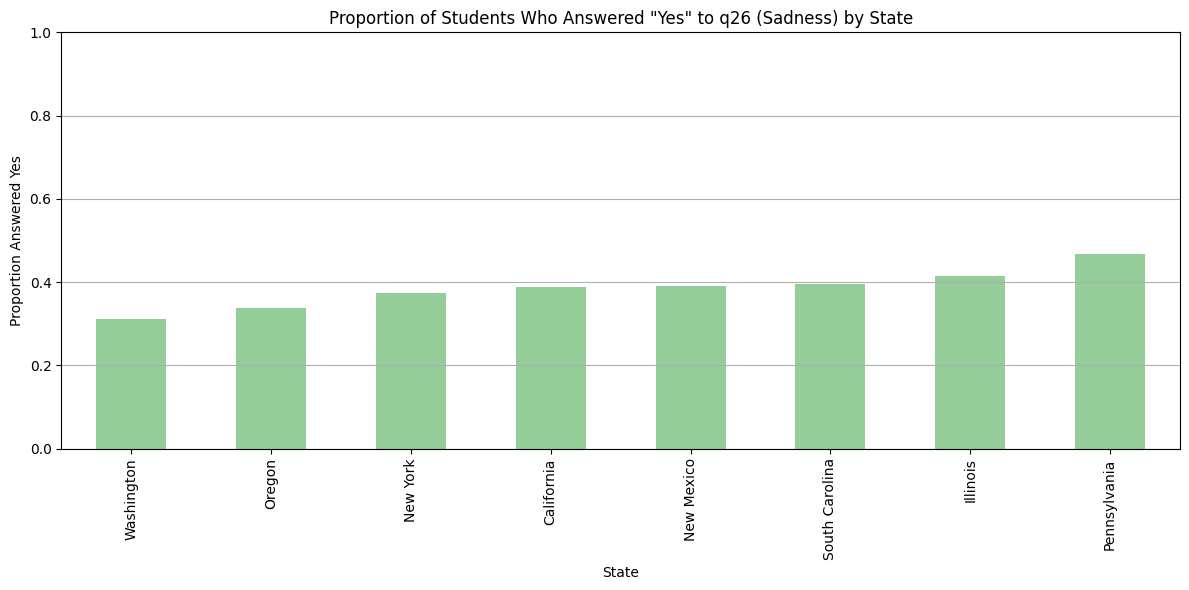

In [ ]:
# Rewriting the entire block using 'full_df' instead of 'df'

# --- Mapping dictionary ---
smoking_drinking_mapping = {
    1: '0 days',
    2: '1-2 days',
    3: '3-5 days',
    4: '6-9 days',
    5: '10-19 days',
    6: '20-29 days',
    7: 'All 30 days'
}

# --- Map temporarily ---
q33_mapped = full_df['q33'].map(smoking_drinking_mapping)
q42_mapped = full_df['q42'].map(smoking_drinking_mapping)

# --- Calculate counts ---
smoking_counts = q33_mapped.value_counts().reindex(smoking_drinking_mapping.values(), fill_value=0)
alcohol_counts = q42_mapped.value_counts().reindex(smoking_drinking_mapping.values(), fill_value=0)

# --- Create dataframe ---
counts_df = pd.DataFrame({
    'Smoking': smoking_counts,
    'Alcohol': alcohol_counts
}, index=smoking_drinking_mapping.values())

colors1 = ['#fba9d6', '#fbbe5a']

# --- Plot Grouped Bar Plot ---
counts_df.plot(kind='bar', figsize=(10,6), color=colors1)
plt.title('Comparison of Smoking and Alcohol Use (Past 30 Days)')
plt.xlabel('Days of Use')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.legend(title='Substance')
plt.grid(axis='y')
plt.show()

# --- Define mappings ---
social_media_mapping = {
    1: 'I do not use',
    2: 'Few times/month',
    3: 'Once/week',
    4: 'Few times/week',
    5: 'Once/day',
    6: 'Several times/day',
    7: 'Once/hour',
    8: 'More than once/hour'
}

sleep_mapping = {
    1: '4 or less',
    2: '5',
    3: '6',
    4: '7',
    5: '8',
    6: '9',
    7: '10+'
}

# --- Temporary dataframe ---
df_temp = full_df[['q80', 'q85']].copy()
df_temp['social_media'] = df_temp['q80'].map(social_media_mapping)
df_temp['sleep'] = df_temp['q85'].map(sleep_mapping)
df_temp.dropna(inplace=True)

# --- Define proper category orders ---
social_order = list(social_media_mapping.values())
sleep_order = list(sleep_mapping.values())

# --- Create cross-tabulation ---
cross_tab = pd.crosstab(df_temp['social_media'], df_temp['sleep'], normalize='index')
cross_tab = cross_tab.reindex(index=social_order, columns=sleep_order)

# --- Plot grouped bar chart ---
cross_tab.plot(kind='bar', figsize=(14,6))
plt.title('Sleep Duration Distribution by Social Media Use Frequency')
plt.xlabel('Social Media Use Frequency')
plt.ylabel('Proportion of Students')
plt.xticks(rotation=45)
plt.legend(title='Sleep Duration', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Mapping dictionaries ---
grades_mapping = {
    1: "Mostly A's",
    2: "Mostly B's",
    3: "Mostly C's",
    4: "Mostly D's",
    5: "Mostly F's",
    6: "None of these",
    7: "Not sure"
}

housing_mapping = {
    1: "Parent/Guardian's Home",
    2: "Someone else's home (unstable)",
    3: "Shelter/Emergency Housing",
    4: "Motel or Hotel",
    5: "Car/Park/Public Place",
    6: "No usual place",
    7: "Somewhere else"
}

# --- Map variables ---
df_temp = full_df[['q87', 'q86']].copy()
df_temp['grades'] = df_temp['q87'].map(grades_mapping)
df_temp['housing'] = df_temp['q86'].map(housing_mapping)
df_temp.dropna(inplace=True)

# --- Define display order ---
grade_order = list(grades_mapping.values())
housing_order = list(housing_mapping.values())

# --- Cross-tabulation normalized by row ---
cross_tab = pd.crosstab(df_temp['housing'], df_temp['grades'], normalize='index')
cross_tab = cross_tab[grade_order]
cross_tab = cross_tab.reindex(housing_order)

# --- Plot ---
cross_tab.plot(kind='bar', figsize=(14,6))
plt.title('Grades Distribution by Usual Sleeping Location (Unstable Housing)')
plt.xlabel('Usual Sleeping Location')
plt.ylabel('Proportion of Students')
plt.xticks(rotation=30, ha='right')
plt.legend(title='Grades', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Mapping ---
bullying_mapping = {1: 'Yes', 2: 'No'}
sadness_mapping = {1: 'Yes', 2: 'No'}

# --- Prepare Data ---
df_temp = full_df[['q24', 'q26']].copy()
df_temp['bullied'] = df_temp['q24'].map(bullying_mapping)
df_temp['sad'] = df_temp['q26'].map(sadness_mapping)
df_temp.dropna(inplace=True)

# --- Count and Normalize ---
grouped = df_temp.groupby(['bullied', 'sad']).size().reset_index(name='count')
grouped['proportion'] = grouped.groupby('bullied')['count'].transform(lambda x: x / x.sum())

# --- Plot Grouped Bar Chart ---
plt.figure(figsize=(8, 6))
sns.barplot(data=grouped, x='bullied', y='proportion', hue='sad', palette='Set2')
plt.title('Proportion of Students Feeling Sad by Bullying Status')
plt.xlabel('Bullied at School')
plt.ylabel('Proportion of Students')
plt.legend(title='Felt Sad or Hopeless (2+ weeks)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Step 1: Filter out rows with missing or invalid q26/state
filtered_df = full_df[(full_df['q26'].isin([1, 2])) & (full_df['state'].notnull())]

# Step 2: Calculate proportion of "Yes" answers per state
yes_proportion = (
    filtered_df.groupby('state')['q26']
    .apply(lambda x: (x == 1).mean())
    .sort_values()
)

# Step 3: Plot the result
plt.figure(figsize=(12, 6))
yes_proportion.plot(kind='bar', color='#95cd98')
plt.title('Proportion of Students Who Answered "Yes" to q26 (Sadness) by State')
plt.xlabel('State')
plt.ylabel('Proportion Answered Yes')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


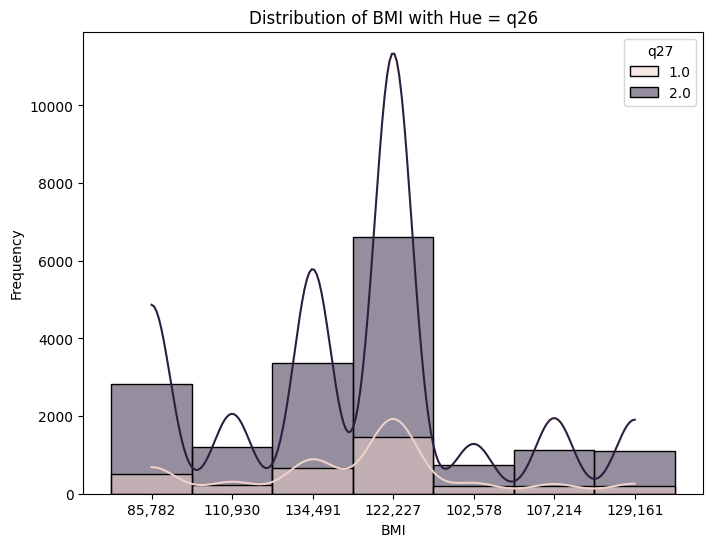

In [ ]:
# prompt: generate a histogram for bmi with hue =q26

import matplotlib.pyplot as plt
# Assuming 'df' DataFrame from the previous code is available

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Mean household income (dollars)', hue='q27', kde=True)  # Added kde for density curve
plt.title('Distribution of BMI with Hue = q26')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()


## Fifth session

In [ ]:
# Define predictors and target
predictors = ['q24', 'sex', 'race4', 'q15', 'q16', 'q18']
target = 'q26'  # Feeling sad or hopeless

# Human-readable labels for the variables
variable_labels = {
    'q24': 'Bullied at School',
    'sex': 'Sex',
    'race4': 'Race (4 Categories)',
    'q15': 'Threatened at School',
    'q16': 'Physical Fighting',
    'q18': 'Saw Violence in Neighborhood',
    'q26': 'Felt Sad or Hopeless'
}

# Drop rows with missing values
full_df_subset = full_df[predictors + [target]].dropna()

# Function to calculate Cramer's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Run chi-square tests and calculate Cramer's V
results = []
for predictor in predictors:
    contingency = pd.crosstab(full_df_subset[predictor], full_df_subset[target])
    chi2, p, dof, expected = chi2_contingency(contingency)
    v = cramers_v(contingency)
    results.append({
        'Predictor': variable_labels[predictor],
        'Target': variable_labels[target],
        'Chi2 Statistic': round(chi2, 2),
        'p-value': round(p, 5),
        'Cramer\'s V': round(v, 3),
        'Significant (p < 0.05)': 'Yes' if p < 0.05 else 'No'
    })

# Create and show the result DataFrame sorted by p-value
chi2_results_df = pd.DataFrame(results).sort_values(by='p-value')
chi2_results_df


,Predictor,Target,Chi2 Statistic,p-value,Cramer's V,Significant (p < 0.05)
0,Bullied at School,Felt Sad or Hopeless,780.51,0.0,0.141,Yes
1,Sex,Felt Sad or Hopeless,1021.05,0.0,0.161,Yes
2,Race (4 Categories),Felt Sad or Hopeless,134.16,0.0,0.058,Yes
3,Threatened at School,Felt Sad or Hopeless,277.18,0.0,0.084,Yes
4,Physical Fighting,Felt Sad or Hopeless,237.51,0.0,0.078,Yes
5,Saw Violence in Neighborhood,Felt Sad or Hopeless,323.70,0.0,0.091,Yes


In [ ]:
# Define predictor list
predictors = ['q24', 'sex', 'race4', 'q15', 'q16', 'q18']

# Human-readable labels for each variable
variable_labels = {
    'q24': 'Bullied at School',
    'sex': 'Sex',
    'race4': 'Race (4 Categories)',
    'q15': 'Threatened at School',
    'q16': 'Physical Fighting',
    'q18': 'Saw Violence in Neighborhood'
}

# Function to calculate Cramer's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Generate all unique predictor pairs
predictor_pairs = list(combinations(predictors, 2))

# Calculate Cramer's V for each pair
v_results = []
for var1, var2 in predictor_pairs:
    sub_df = full_df[[var1, var2]].dropna()
    contingency = pd.crosstab(sub_df[var1], sub_df[var2])
    v = cramers_v(contingency)
    v_results.append({
        'Variable 1': variable_labels[var1],
        'Variable 2': variable_labels[var2],
        "Cramer's V": round(v, 3)
    })

# Show results as a DataFrame
cramers_v_df = pd.DataFrame(v_results).sort_values(by="Cramer's V", ascending=False)
cramers_v_df


,Variable 1,Variable 2,Cramer's V
2,Bullied at School,Threatened at School,0.333
4,Bullied at School,Saw Violence in Neighborhood,0.219
14,Physical Fighting,Saw Violence in Neighborhood,0.191
12,Threatened at School,Physical Fighting,0.144
3,Bullied at School,Physical Fighting,0.121
13,Threatened at School,Saw Violence in Neighborhood,0.115
9,Race (4 Categories),Threatened at School,0.109
5,Sex,Race (4 Categories),0.097
7,Sex,Physical Fighting,0.084
10,Race (4 Categories),Physical Fighting,0.083


## Simple Predictive Baseline

In [ ]:
# 1. Constant Baseline

# --- Define target and drop non-predictive columns ---
target = 'q26'
exclude = ['q27', 'q84']
X = full_df.drop(columns=[target] + exclude)
y = full_df[target]

# --- One-hot encode categorical variables ---
X_encoded = pd.get_dummies(X, drop_first=True)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

# --- Constant baseline: always predict most frequent class ---
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

# --- Predict on train and test sets ---
y_train_pred = dummy.predict(X_train)
y_test_pred = dummy.predict(X_test)

# --- Evaluation ---
print("Constant Baseline Results:")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


Constant Baseline Results:
Train Accuracy: 0.6148653553023155
Test Accuracy: 0.6149026248941575


In [ ]:
# 2. Univariate Logistic Regression (One Predictor Only)

# Step 1: Filter only valid q26 values (1 = Yes, 2 = No)
df_uni = full_df[full_df['q26'].isin([1, 2])].copy()

# Step 2: Make target binary (1 = sadness, 0 = no sadness)
df_uni['sad'] = df_uni['q26'].map({1: 1, 2: 0})

# Step 3: Use q24 (bullied at school) as predictor, also binary encode it
df_uni['bullied'] = df_uni['q24'].map({1: 1, 2: 0})  # 1 = bullied, 0 = not bullied

# Step 4: Drop rows with NaNs (just in case)
df_uni = df_uni.dropna(subset=['sad', 'bullied'])

# Step 5: Prepare X and y
X = df_uni[['bullied']]
y = df_uni['sad']

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 7: Train model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 8: Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Step 9: Evaluate
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", test_mse)

# Labeled confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
cm_df = pd.DataFrame(cm,
                     index=["Actual 0 (No Sadness)", "Actual 1 (Yes Sadness)"],
                     columns=["Predicted 0 (No Sadness)", "Predicted 1 (Yes Sadness)"])
print("\nConfusion Matrix (Test):\n", cm_df)


Train Accuracy: 0.6500038931713774
Test Accuracy: 0.6552225249772934
Test MSE: 0.3447774750227066

Confusion Matrix (Test):
                         Predicted 0 (No Sadness)  Predicted 1 (Yes Sadness)
Actual 0 (No Sadness)                       3054                        340
Actual 1 (Yes Sadness)                      1558                        553


## Sparse Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import pandas as pd

# Step 1: Filter and prepare dataset
df_sparse = full_df[full_df['q26'].isin([1, 2])].copy()
df_sparse['target'] = df_sparse['q26'].map({1: 1, 2: 0})  # Binary: 1 = sad, 0 = not sad

# Step 2: Drop unwanted columns
X = df_sparse.drop(columns=['q26', 'q27', 'q84', 'target', 'state', 'sitename', 'q30', 'q29', 'q28'])
y = df_sparse['target']

# Step 3: Rename variable names to human-readable labels
column_renames = {
    'gdp 2023': "GDP per state (2023)",
    'Mean household income (dollars)': "Mean household income",
    'Unemployment Rate(Percent)': "Unemployment rate (%)",
    'sexpart': "Sex of sexual contact(s)",
    'q18': "Witnessed physical attack in neighborhood",
    'sexpart2': "Collapsed sex of sexual contact(s)",
    'q23': "Felt unfair treatment at school due to race/ethnicity",
    'q24': "Bullied on school property (past 12 months)",
    'q85': "Hours of sleep on school night",
    'sex': "Sex",
    'qclose2people': "Feel close to people at school",
    'transg': "Transgender identity",
    'q75': "Days ate breakfast (past 7 days)",
    'sextrans': "Sexual and gender identity",
    'q14': "Missed school due to feeling unsafe (past 30 days)",
    'q49': "Non-prescribed pain med use (lifetime)",
    'q54': "Used ecstasy (lifetime)",
    'q78': "Sports teams played (past 12 months)",
    'q19': "Physically forced to have sex",
    'q8': "Seatbelt use when riding in car"
}
X = X.rename(columns=column_renames)

# Step 4: One-hot encode and scale
X_encoded = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Step 5: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Step 6: Train sparse logistic regression
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

# Step 7: Evaluation
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", test_mse)

# Step 8: Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
cm_df = pd.DataFrame(cm,
                     index=["Actual 0 (No Sadness)", "Actual 1 (Yes Sadness)"],
                     columns=["Predicted 0 (No Sadness)", "Predicted 1 (Yes Sadness)"])
print("\nConfusion Matrix (Test):\n", cm_df)

# Step 9: Show non-zero features
coef_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': model.coef_[0]
})
non_zero = coef_df[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', key=abs, ascending=False)
print("\nTop Non-Zero Coefficients (Selected Features):\n")
print(non_zero.head(20))


Train Accuracy: 0.738049992691127
Test Accuracy: 0.7159420289855073
Test MSE: 0.28405797101449276

Confusion Matrix (Test):
                         Predicted 0 (No Sadness)  Predicted 1 (Yes Sadness)
Actual 0 (No Sadness)                       3080                        551
Actual 1 (Yes Sadness)                      1115                       1119

Top Non-Zero Coefficients (Selected Features):

                                              Feature  Coefficient
90                               GDP per state (2023)     1.245335
92                              Mean household income    -0.525470
91                              Unemployment rate (%)    -0.506540
20                           Sex of sexual contact(s)     0.499093
34          Witnessed physical attack in neighborhood    -0.496042
21                 Collapsed sex of sexual contact(s)    -0.393930
39  Felt unfair treatment at school due to race/et...     0.364901
40        Bullied on school property (past 12 months)    -0.30

<ipython-input-93-cc95d22c1353>:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='coolwarm')


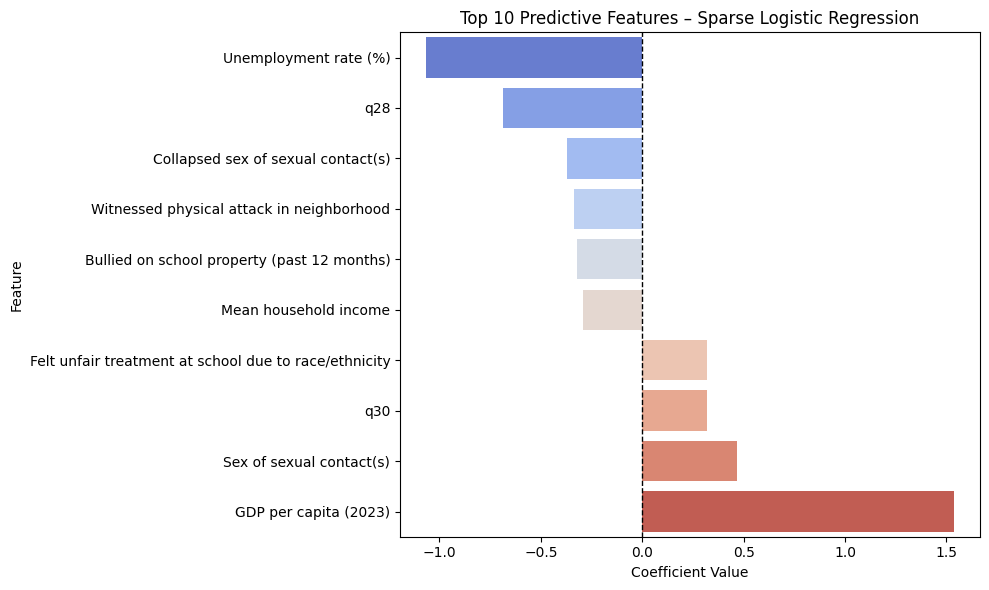

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter and prepare dataset
df_sparse = full_df[full_df['q26'].isin([1, 2])].copy()
df_sparse['target'] = df_sparse['q26'].map({1: 1, 2: 0})  # Binary: 1 = sad, 0 = not sad

# Step 2: Drop unwanted columns
X = df_sparse.drop(columns=['q26', 'q27', 'q84', 'target', 'state', 'sitename'])
y = df_sparse['target']

# Step 2.5: Rename variables for clarity
column_renames = {
    'sexpart': "Sex of sexual contact(s)",
    'q18': "Witnessed physical attack in neighborhood",
    'sexpart2': "Collapsed sex of sexual contact(s)",
    'q23': "Felt unfair treatment at school due to race/ethnicity",
    'q24': "Bullied on school property (past 12 months)",
    'q85': "Hours of sleep on school night",
    'sex': "Sex",
    'qclose2people': "Feel close to people at school",
    'transg': "Transgender identity",
    'q75': "Days ate breakfast (past 7 days)",
    'sextrans': "Sexual and gender identity",
    'q14': "Missed school due to feeling unsafe (past 30 days)",
    'q49': "Non-prescribed pain med use (lifetime)",
    'q54': "Used ecstasy (lifetime)",
    'q78': "Sports teams played (past 12 months)",
    'q19': "Physically forced to have sex",
    'q8': "Seatbelt use when riding in car",
    'gdp 2023': "GDP per capita (2023)",
    'Mean household income (dollars)': "Mean household income",
    'Unemployment Rate(Percent)': "Unemployment rate (%)"
}
X = X.rename(columns=column_renames)

# Step 3: One-hot encode and scale
X_encoded = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Step 5: Train sparse logistic regression
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

# Step 6: Extract non-zero coefficients
coef_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': model.coef_[0]
})
non_zero = coef_df[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', key=abs, ascending=False)

# Step 7: Plot top 10 non-zero coefficients
top_features = non_zero.head(10).copy()
top_features = top_features.sort_values(by='Coefficient')  # for horizontal bar plot

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=top_features, palette='coolwarm')
plt.title('Top 10 Predictive Features – Sparse Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()
